# Install

Only need these the very first time ever running this:

In [ ]:
] instantiate

In [ ]:
; pip install camb

# Initialize

In [1]:
using Flux, CUDA, Adapt, CMBLensing, PyPlot, LinearAlgebra, ProgressMeter, Setfield

┌ Warning: CUDA.jl found cuda, but did not find libcudnn. Some functionality will not be available.
└ @ Flux /home/marius/.julia/packages/Flux/qp1gc/src/Flux.jl:63


Set to true to use GPU:

In [2]:
Flux.use_cuda[] = false

false

In [3]:
storage = Flux.use_cuda[] ? CuArray : Array;

Loads a CMB simulation and the simulated signal and noise covariance needed:

In [4]:
@unpack f, n, ds = load_sim(; storage, Nside=64, θpix=2, pol=:I, μKarcminT=150, seed=0, bandpass_mask=LowPass(3000));

In [5]:
M = Diagonal(adapt(storage, make_mask(f, edge_padding_deg=0.2, apodization_deg=0.2, edge_rounding_deg=0.1, num_ptsrcs=0)));
fwf = argmaxf_lnP(I, (;), @set(ds.Cf=ds.Cf̃));

The linear combination network layer described in the WienerNet paper (which doesn't exist as a built-in in Flux):

In [6]:
struct LinearCombo{T}
    c :: T
end
LinearCombo() = LinearCombo([1f0])
(lc::LinearCombo)(x, y) = @. x + lc.c * y
Flux.@functor LinearCombo

# Model

Build the network:

In [7]:
Nfeatures = 10;
Nlayers = 1;

In [9]:
network = SkipConnection(
    Chain(
        Conv((5,5), Nfeatures=>Nfeatures, stride=2, pad=SamePad()),
        ConvTranspose((5,5), Nfeatures=>Nfeatures, stride=2, pad=SamePad())
    ),
    LinearCombo()
)

for i = reverse(1:Nlayers)
    network = SkipConnection(
        Chain(
            Conv((5,5), (i==1 ? 1 : Nfeatures)=>Nfeatures, stride=2, pad=SamePad()),
            network,
            ConvTranspose((5,5), Nfeatures=>(i==1 ? 1 : Nfeatures), stride=2, pad=SamePad())
        ),
        LinearCombo()
    )
end
network = Flux.gpu(network)

model(x) = network(x)
model(f::Field) = FlatMap(model(f[:Ix][:,:,:,:])[:,:,1,1], f.metadata)

model (generic function with 2 methods)

# Data

The training data:

In [12]:
dfs = @showprogress map(1:64) do i
    @unpack d,f,f̃ = resimulate(ds,seed=i)
    d[:Ix][:,:,:,:], f̃[:Ix][:,:,:,:]
end;

xs = cat(first.(dfs)..., dims=4)
ys = cat(last.(dfs)...,  dims=4);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


# Loss function

$J_2$ or $J_3$ loss functions from the paper:

In [13]:
loss_J2(x,d) = Flux.mse(model(x), d);

function loss_J3(x, d)
    y = FlatMap(model(x), f.metadata)
    Δ = ds.M * ds.B * y - FlatMap(d, f.metadata)
    sum(unbatch(Δ' * pinv(ds.Cn) * Δ + y' * pinv(ds.Cf̃) * y))
end

loss_J3 (generic function with 1 method)

# Train

In [14]:
opt = ADAM(1e-3)

@showprogress for i=1:100
    Flux.Optimise.train!(loss_J2, params(network), [(xs,ys)], opt);
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:01


# Examine

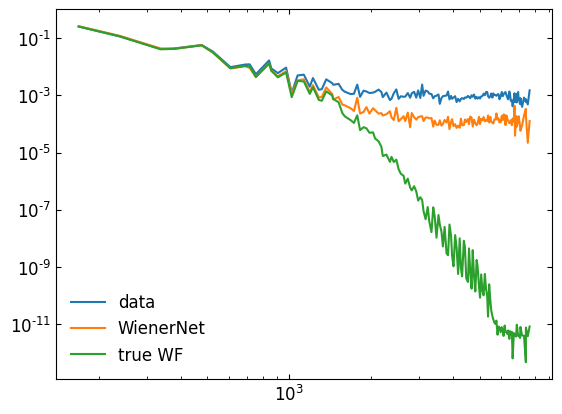

PyObject <matplotlib.legend.Legend object at 0x7f8e481992e8>

In [15]:
loglog(get_Cℓ(M*ds.d), label="data")
loglog(get_Cℓ(M*model(ds.d)), label="WienerNet")
loglog(get_Cℓ(M*fwf), label="true WF")
legend()

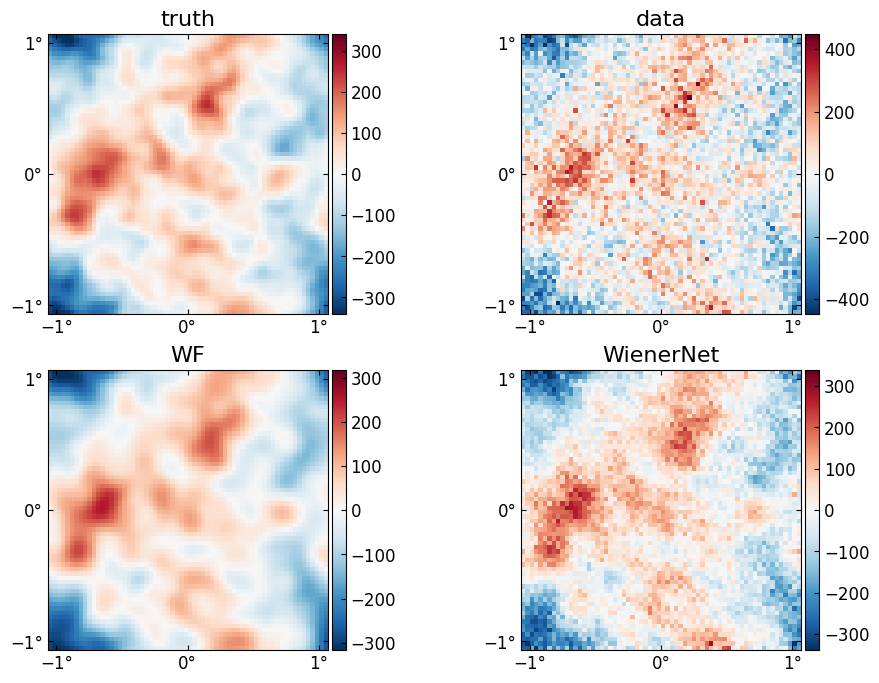

In [16]:
plot(
    [
        f   ds.d;
        fwf FlatMap(model((ds.d)[:Ix][:,:,:,:])[:,:,1,1], f.metadata)
    ],
    title=["truth" "data"; "WF" "WienerNet"]
)